# Mini Challenge: Deep Learning for Images and Signals
- Name: Nils Fahrni
- Submission Date: t.b.d.

## How does the performance of a U-Net semantic segmentation model differ between scenes of city streets and non-city streets in the BDD100K dataset?

## Package Usage

In [1]:
#%env WANDB_SILENT=True
%env "WANDB_NOTEBOOK_NAME" "dlbs"

import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import wandb
import random

env: "WANDB_NOTEBOOK_NAME"="dlbs"


In [2]:
RANDOM_SEED = 1337

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Dataset
Berkeley Deep Drive Dataset: https://arxiv.org/abs/1805.04687

In [3]:
import os

BASE_DATA_PATH = os.path.join('data', 'bdd100k', 'images', '10k', 'train')
BASE_LABELS_PATH = os.path.join('data', 'bdd100k', 'labels', 'sem_seg', 'masks', 'train')

### Exploration

[Become one with the data](https://karpathy.github.io/2019/04/25/recipe/#:~:text=1.%20Become%20one%20with%20the%20data)

#### Metrics

#### Looking at some samples

#### Spatial Heatmap

https://doc.bdd100k.com/format.html#semantic-segmentation

In [4]:
class_dict = {
    0: "road",
    1: "sidewalk",
    2: "building",
    3: "wall",
    4: "fence",
    5: "pole",
    6: "traffic light",
    7: "traffic sign",
    8: "vegetation",
    9: "terrain",
    10: "sky",
    11: "person",
    12: "rider",
    13: "car",
    14: "truck",
    15: "bus",
    16: "train",
    17: "motorcycle",
    18: "bicycle"
}

In [5]:
%%script false --no-raise-error

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
from tqdm import tqdm

label_folder = BASE_LABELS_PATH

target_width, target_height = 128, 228
N_SAMPLES = 1000

heatmaps = {class_id: np.zeros((target_height, target_width), dtype=np.float32) for class_id in class_dict.keys()}

for class_id, class_name in tqdm(class_dict.items(), desc="Processing Classes"):
    all_files = [f for f in os.listdir(label_folder) if f.endswith('.png')]
    sampled_files = random.sample(all_files, min(N_SAMPLES, len(all_files)))
    
    for file in tqdm(sampled_files, desc=f"Sampling {class_name}", leave=False):
        label_path = os.path.join(label_folder, file)
        with Image.open(label_path) as img:
            label = np.array(img)
            
            label_resized = np.array(Image.fromarray(label).resize((target_width, target_height), Image.NEAREST))

            mask = (label_resized == class_id)
            heatmaps[class_id] += mask.astype(np.float32)

    heatmaps[class_id] /= len(sampled_files)

fig, axs = plt.subplots(4, 5, figsize=(20, 15))
fig.suptitle("Spatial Heatmaps for all Classes", fontsize=20)

for class_id, class_name in class_dict.items():
    ax = axs[class_id // 5, class_id % 5]
    sns.heatmap(heatmaps[class_id], ax=ax, cmap="viridis", cbar=False)
    ax.set_title(class_name)
    ax.axis('off')

for i in range(len(class_dict), 4 * 5):
    fig.delaxes(axs[i // 5, i % 5])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Couldn't find program: 'false'


**Observations**
- Train, Rider, Motorcycle and bicycle seem to be rather underrepresented since these objects' shapes are still clearly visible and don't have a high overlap

#### Co-Occurence

In [6]:
%%script false --no-raise-error

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

label_folders = [BASE_LABELS_PATH]
num_classes = len(class_dict)
class_names = list(class_dict.values())

co_occurrence_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

for label_folder in label_folders:
    all_files = [f for f in os.listdir(label_folder) if f.endswith('.png')]
    
    for file in tqdm(all_files, desc=f"Processing Masks in {label_folder}"):
        label_path = os.path.join(label_folder, file)
        with Image.open(label_path) as img:
            label = np.array(img)

            unique_classes = np.unique(label)

            for i in range(len(unique_classes)):
                for j in range(i, len(unique_classes)):
                    class_i = unique_classes[i]
                    class_j = unique_classes[j]
                    if class_i < num_classes and class_j < num_classes:
                        co_occurrence_matrix[class_i, class_j] += 1
                        if class_i != class_j:
                            co_occurrence_matrix[class_j, class_i] += 1

plt.figure(figsize=(12, 10))
ax = sns.heatmap(co_occurrence_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Class Co-Occurrence Matrix for Train and Val Sets", pad=20)
plt.xlabel("Class")
plt.ylabel("Class")

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

plt.xticks(rotation=45, ha="left")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Couldn't find program: 'false'


### Training and Evaluation Skeleton

[Set up the end-to-end training/evaluation skeleton + get dumb baselines](https://karpathy.github.io/2019/04/25/recipe/#:~:text=Set%20up%20the%20end%2Dto%2Dend%20training/evaluation%20skeleton%20%2B%20get%20dumb%20baselines)

In [7]:
import torch
import torch.nn as nn
from torcheval.metrics import MulticlassAccuracy

RANDOM_SEED = 1337

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


#### Data Loading & Splitting

In [8]:
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import torch

from data import BDD100KDataset, custom_split_dataset_with_det, check_dataset_overlap

DET_TRAIN_PATH = './data/bdd100k/labels/det_20/det_train.json'
DET_VAL_PATH = './data/bdd100k/labels/det_20/det_val.json'

split_data = custom_split_dataset_with_det(base_data_path=BASE_DATA_PATH, 
                                           base_labels_path=BASE_LABELS_PATH, 
                                           det_train_path=DET_TRAIN_PATH, 
                                           det_val_path=DET_VAL_PATH)

check_dataset_overlap(
    split_data['train']['image_filenames'],
    split_data['val']['image_filenames'],
    split_data['test']['image_filenames']
)

image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

label_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Lambda(lambda x: torch.tensor(np.array(x), dtype=torch.long)),
])

train_dataset = BDD100KDataset(
    images_dir=split_data['train']['data_folder'],
    labels_dir=split_data['train']['labels_folder'],
    filenames=split_data['train']['image_filenames'],
    transform=image_transform,
    target_transform=label_transform,
    scene_info=split_data['train']['scene_map']
)

val_dataset = BDD100KDataset(
    images_dir=split_data['val']['data_folder'],
    labels_dir=split_data['val']['labels_folder'],
    filenames=split_data['val']['image_filenames'],
    transform=image_transform,
    target_transform=label_transform,
    scene_info=split_data['val']['scene_map']
)

test_dataset = BDD100KDataset(
    images_dir=split_data['test']['data_folder'],
    labels_dir=split_data['test']['labels_folder'],
    filenames=split_data['test']['image_filenames'],
    transform=image_transform,
    target_transform=label_transform,
    scene_info=split_data['test']['scene_map']
)


--- Split Sizes ---
- Train Images: 2518
- Val Images: 454
- Test Images: 454

--- Overlap Report ---
✔️ No overlap detected between train and validation sets.
✔️ No overlap detected between train and test sets.
✔️ No overlap detected between validation and test sets.



In [9]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import trange

def map_class_names_and_order(class_distribution, class_dict):
    ordered_classes = sorted(class_dict.keys())  # Ensure consistent class order
    class_names = [class_dict[class_id] for class_id in ordered_classes if class_id in class_distribution]
    proportions = [class_distribution[class_id] for class_id in ordered_classes if class_id in class_distribution]
    return class_names, proportions

def plot_class_distribution(class_distribution, title, class_dict):
    class_names, proportions = map_class_names_and_order(class_distribution, class_dict)
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_names, proportions, color='skyblue', edgecolor='black')
    
    for bar, proportion in zip(bars, proportions):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 f"{proportion * 100:.2f}%", ha='center', va='bottom', fontsize=9)

    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xlabel('Class')
    plt.ylabel('Proportion of Pixels')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def analyze_class_distribution(dataset, num_classes, dataset_name):
    class_counts = Counter()
    
    for idx in trange(len(dataset), desc=f"Analyzing {dataset_name}"):
        try:
            _, mask, _ = dataset[idx]  # Access dataset item
            mask_array = np.array(mask)  # Convert mask to numpy array
            unique, counts = np.unique(mask_array, return_counts=True)
            class_counts.update(dict(zip(unique, counts)))
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            continue

    # Normalize counts
    total_pixels = sum(class_counts.values())
    class_distribution = {cls: count / total_pixels for cls, count in class_counts.items()}

    return class_counts, class_distribution

train_class_counts, train_class_distribution = analyze_class_distribution(train_dataset, num_classes=19, dataset_name="Train")
val_class_counts, val_class_distribution = analyze_class_distribution(val_dataset, num_classes=19, dataset_name="Validation")
test_class_counts, test_class_distribution = analyze_class_distribution(test_dataset, num_classes=19, dataset_name="Test")

Analyzing Test: 100%|██████████| 454/454 [00:05<00:00, 77.28it/s]


In [10]:
import collections

ordered_class_dists = collections.OrderedDict(sorted(train_class_distribution.items()))
class_weights = torch.tensor(
    list(ordered_class_dists.values()), dtype=torch.float32, device=device
)[:-1]

In [11]:
train_class_distribution

{0: 0.21008663835661018,
 1: 0.023452323824022594,
 2: 0.1422820363521534,
 4: 0.011003414305886507,
 5: 0.01080182753618392,
 6: 0.0023026483623466596,
 7: 0.004159849431316742,
 8: 0.12340678365766482,
 10: 0.13316542767077044,
 13: 0.08020916932806019,
 14: 0.009596055966485747,
 255: 0.22292993054176596,
 11: 0.0027746406429264847,
 3: 0.005939871811843615,
 15: 0.006420913519879092,
 9: 0.009870512173462184,
 12: 0.0003030696347409761,
 17: 0.00032172869230429795,
 18: 0.0008944712652237225,
 16: 7.868692635248433e-05}

In [12]:
train_dataset[:][1]

(tensor([[[0.3569, 0.2392, 0.0745,  ..., 0.3373, 0.3373, 0.3333],
          [0.3725, 0.2118, 0.0784,  ..., 0.3412, 0.3412, 0.3412],
          [0.3882, 0.1922, 0.0863,  ..., 0.3490, 0.3529, 0.3529],
          ...,
          [0.1294, 0.1294, 0.1333,  ..., 0.4157, 0.4314, 0.4353],
          [0.1216, 0.1216, 0.1255,  ..., 0.5804, 0.5725, 0.5647],
          [0.1255, 0.1216, 0.1255,  ..., 0.4745, 0.5059, 0.4902]],
 
         [[0.6784, 0.4118, 0.1373,  ..., 0.6078, 0.6078, 0.6039],
          [0.6745, 0.3686, 0.1373,  ..., 0.6118, 0.6118, 0.6118],
          [0.6706, 0.3333, 0.1569,  ..., 0.6196, 0.6235, 0.6235],
          ...,
          [0.1922, 0.1922, 0.1961,  ..., 0.4745, 0.4863, 0.4941],
          [0.1843, 0.1882, 0.1922,  ..., 0.6392, 0.6314, 0.6275],
          [0.1882, 0.1882, 0.1961,  ..., 0.5333, 0.5608, 0.5451]],
 
         [[0.9373, 0.5725, 0.2000,  ..., 0.8627, 0.8627, 0.8588],
          [0.9294, 0.5059, 0.2039,  ..., 0.8667, 0.8667, 0.8667],
          [0.9137, 0.4471, 0.2196,  ...,

In [13]:
label_of_first_image = train_dataset[0][1]

# flatten the labels into a single list
all_masks = [sample[1] for sample in train_dataset]

# Flatten and concatenate all masks
flat_labels = np.concatenate([np.array(mask).flatten() for mask in all_masks])


KeyboardInterrupt: 

In [55]:
classes = list(range(0, 19))
classes.append(255)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]

In [49]:
flat_labels.shape

(23205888,)

In [66]:
from sklearn.utils.class_weight import compute_class_weight

classes = list(range(0, 19))
classes.append(255)

class_weights_1 = compute_class_weight(train_class_distribution, classes=np.array(classes), y=flat_labels)[:-1]

class_weights_balanced = compute_class_weight("balanced", classes=np.array(classes), y=flat_labels)[:-1]

In [68]:
class_weights, class_weights_1, class_weights_balanced

(tensor([2.1009e-01, 2.3452e-02, 1.4228e-01, 5.9399e-03, 1.1003e-02, 1.0802e-02,
         2.3026e-03, 4.1598e-03, 1.2341e-01, 9.8705e-03, 1.3317e-01, 2.7746e-03,
         3.0307e-04, 8.0209e-02, 9.5961e-03, 6.4209e-03, 7.8687e-05, 3.2173e-04,
         8.9447e-04], device='cuda:0'),
 array([2.10086638e-01, 2.34523238e-02, 1.42282036e-01, 5.93987181e-03,
        1.10034143e-02, 1.08018275e-02, 2.30264836e-03, 4.15984943e-03,
        1.23406784e-01, 9.87051217e-03, 1.33165428e-01, 2.77464064e-03,
        3.03069635e-04, 8.02091693e-02, 9.59605597e-03, 6.42091352e-03,
        7.86869264e-05, 3.21728692e-04, 8.94471265e-04]),
 array([2.37997049e-01, 2.13198489e+00, 3.51414706e-01, 8.41769008e+00,
        4.54404411e+00, 4.62884635e+00, 2.17141274e+01, 1.20196658e+01,
        4.05164113e-01, 5.06559327e+00, 3.75472830e-01, 1.80203516e+01,
        1.64978587e+02, 6.23370126e-01, 5.21047399e+00, 7.78705395e+00,
        6.35429573e+02, 1.55410447e+02, 5.58989449e+01]))

In [10]:
%%script false --no-raise-error

plot_class_distribution(train_class_distribution, "Train Class Distribution", class_dict)
plot_class_distribution(val_class_distribution, "Validation Class Distribution", class_dict)
plot_class_distribution(test_class_distribution, "Test Class Distribution", class_dict)

#### Training and Evaluation Skeleton

In [11]:
from trainer import Trainer
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

### Baseline: (Tiny-)U-Net

In [15]:
overfit_datalader = DataLoader(train_dataset[:8], batch_size=8, shuffle=True)

In [16]:
import torch.optim as optim
import torch.nn as nn
from core import UNetBaseline

model = UNetBaseline(num_classes=19).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=255, weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

Trainer(model,
        criterion, 
        optimizer,
        epochs=50,
        seed=RANDOM_SEED, 
        device=device, 
        verbose=True, 
        run_name="unet_baseline").run(train_dataloader, 
                                      val_dataloader)

Model trainer was already initialized. Skipping wandb initialization.
Model unet_baseline already exists! Skipping training.


### Overfit

[Overfit](https://karpathy.github.io/2019/04/25/recipe/#:~:text=3.-,Overfit,-At%20this%20stage)

In [19]:
import os

import wandb
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch

MODELS_PATH = "models"

class Analyzer:
    def __init__(self, run_id, project_name, entity_name, test_dataset, model, device="cpu"):
        """
        Initializes the Analyzer object with run details.

        Parameters:
            run_id (str): The ID of the wandb run.
            project_name (str): The name of the wandb project.
            entity_name (str): The name of the wandb entity.
        """
        self.run_id = run_id
        self.project_name = project_name
        self.entity_name = entity_name
        self.history = None
        self.test_dataset = test_dataset
        self.device = device
        self.model = model.to(device)

    def _load_model(self):
        models = os.listdir(MODELS_PATH)
        
        for model in models:
            if self.run_id in model:
                model_state = torch.load(os.path.join(MODELS_PATH, model))
                
                self.model.load_state_dict(model_state)
                
                return self.model

    def _test_n_samples(self, test_sample_ids: list = None):
        model = self._load_model()
        for idx in test_sample_ids:
            image, label, scene = self.test_dataset[idx]
            
            print(f"Image shape: {image.shape}")
            print(f"Label shape: {label.shape}")
            print(f"Scene: {scene}")
            
            model.eval()
            with torch.no_grad():
                image = image.unsqueeze(0).to(self.device)
                output = model(image)
                pred = output.argmax(1).squeeze(0).cpu().numpy()
                
                cmap = plt.get_cmap('tab20')
                unique_classes = list(range(19))  # Adjust if there are fewer/more classes
                legend_patches = [mpatches.Patch(color=cmap(i / len(unique_classes)), label=f'Class {i}') for i in unique_classes]

                print(pred, label)

                plt.figure(figsize=(12, 6))

                # Ground Truth subplot
                plt.subplot(1, 2, 1)
                plt.imshow(label, cmap='tab20')
                plt.title("Ground Truth")
                plt.axis('off')
                plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.2, 1.0), title="Classes")

                # Prediction subplot
                plt.subplot(1, 2, 2)
                plt.imshow(pred, cmap='tab20')
                plt.title("Prediction")
                plt.axis('off')
                plt.legend(handles=legend_patches, loc='upper right', bbox_to_anchor=(1.2, 1.0), title="Classes")

                plt.tight_layout()
                plt.show()

    def _fetch_data(self):
        """
        Fetches the run data from wandb using the API.
        """
        # Initialize API
        api = wandb.Api()

        # Fetch the run
        try:
            run = api.run(f"{self.entity_name}/{self.project_name}/{self.run_id}")
            self.history = run.history()
        except wandb.errors.CommError as e:
            raise ValueError(f"Error fetching run: {e}")

    def plot(self):
        """
        Plots the train and validation loss for the specified wandb run.
        """
        if self.history is None:
            self._fetch_data()

        # Check if 'train_loss' and 'val_loss' exist in the history
        if 'train_loss' not in self.history or 'val_loss' not in self.history:
            raise ValueError("The run does not have 'train_loss' and/or 'val_loss' logged.")

        # Plot train and validation loss
        plt.figure(figsize=(10, 6))
        plt.plot(self.history['train_loss'], label='Train Loss')
        plt.plot(self.history['val_loss'], label='Validation Loss', linestyle='--')
        plt.title(f"Train and Validation Loss for Run {self.run_id}")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()


C:\Users\fahrn\AppData\Local\Temp\ipykernel_30352\3525104511.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state = torch.load(os.path.join(MODELS_PATH, model))


Image shape: torch.Size([3, 72, 128])
Label shape: torch.Size([72, 128])
Scene: residential
[[ 4  2  7 ...  2 15 15]
 [ 4  2 18 ... 18 18  3]
 [ 4  2 18 ... 18 18  3]
 ...
 [13 18 18 ... 18 18 18]
 [ 4 18 18 ... 18 18 18]
 [18 18 18 ... 18 18 18]] tensor([[  8,   8,   8,  ..., 255, 255, 255],
        [  8,   8,   8,  ..., 255, 255, 255],
        [  8,   8,   8,  ..., 255, 255, 255],
        ...,
        [255, 255, 255,  ...,  13,  13,  13],
        [255, 255, 255,  ...,  13,  13,  13],
        [255, 255, 255,  ...,  13,  13,  13]])


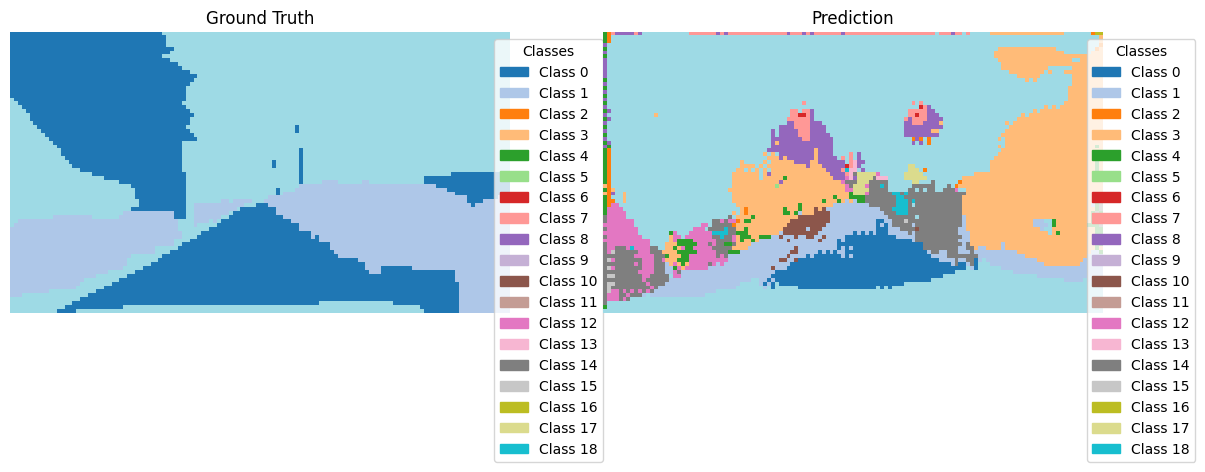

Image shape: torch.Size([3, 72, 128])
Label shape: torch.Size([72, 128])
Scene: city street
[[14 14 14 ... 10 10 10]
 [14 14 14 ... 10 10 10]
 [14 14 14 ... 10 10 10]
 ...
 [ 0 13  0 ...  0  0  1]
 [13 13 18 ...  0  0  1]
 [15  0 18 ...  0  0  0]] tensor([[  2,   2,   2,  ...,  10,  10,  10],
        [  2,   2,   2,  ...,  10,  10,  10],
        [  2,   2,   2,  ...,  10,  10,  10],
        ...,
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255],
        [255, 255, 255,  ..., 255, 255, 255]])


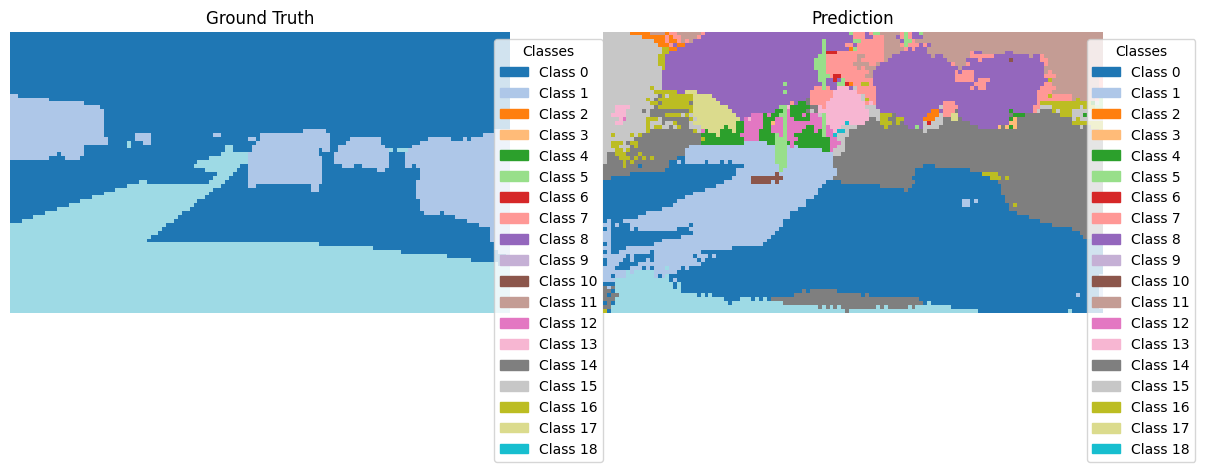

In [20]:
from core import VanillaUNet

Analyzer(run_id="6zef8gfm", project_name="dlbs", entity_name="okaynils", test_dataset=test_dataset, model=VanillaUNet(num_classes=19, base_filters=128))._test_n_samples([1,2])

In [17]:
import torch.optim as optim
import torch.nn as nn
from core import UNet

baseline_encoder_dims = [64, 128, 256, 512]
baseline_decoder_dims = [512, 256, 128, 64]

encoder_dims = baseline_encoder_dims[:]
decoder_dims = baseline_decoder_dims[:]

for iteration in range(2):
    print(f"Iteration {iteration + 1}: Training with encoder_dims={encoder_dims} and decoder_dims={decoder_dims}")
    
    model = UNet(num_classes=19, encoder_dims=encoder_dims, decoder_dims=decoder_dims).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=255, weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    
    Trainer(model,
            criterion, 
            optimizer,
            epochs=50,
            seed=RANDOM_SEED, 
            device=device, 
            verbose=True, 
            run_name=f"unet_overfit_iteration_{iteration + 1}").run(train_dataloader, 
                                                                    val_dataloader)
    
    next_dim = encoder_dims[-1] * 2
    encoder_dims.append(next_dim)
    decoder_dims.insert(0, next_dim)
    print(decoder_dims)

Iteration 1: Training with encoder_dims=[64, 128, 256, 512] and decoder_dims=[512, 256, 128, 64]


epoch,▁█
train_iou,█▁
train_loss,▁█
val_iou,█▁
val_loss,▁█
epoch,2
train_iou,0.01552
train_loss,4.01882
val_iou,0.01541
val_loss,4.03323


Epoch 1/50 - Train Loss: 0.8648, Train IoU: 0.1291 - Val Loss: 0.5913, Val IoU: 0.1511
Model saved to models\unet_overfit_iteration_1_x8mef9g2.pth with val_loss 0.5913
Epoch 2/50 - Train Loss: 0.5270, Train IoU: 0.1554 - Val Loss: 0.5592, Val IoU: 0.1544
Model saved to models\unet_overfit_iteration_1_x8mef9g2.pth with val_loss 0.5592
Epoch 3/50 - Train Loss: 0.4710, Train IoU: 0.1635 - Val Loss: 0.5121, Val IoU: 0.1662
Model saved to models\unet_overfit_iteration_1_x8mef9g2.pth with val_loss 0.5121
Epoch 4/50 - Train Loss: 0.4407, Train IoU: 0.1685 - Val Loss: 0.4919, Val IoU: 0.1680
Model saved to models\unet_overfit_iteration_1_x8mef9g2.pth with val_loss 0.4919
Epoch 5/50 - Train Loss: 0.4138, Train IoU: 0.1730 - Val Loss: 0.4583, Val IoU: 0.1743
Model saved to models\unet_overfit_iteration_1_x8mef9g2.pth with val_loss 0.4583
Epoch 6/50 - Train Loss: 0.3936, Train IoU: 0.1766 - Val Loss: 0.4957, Val IoU: 0.1713
Epoch 7/50 - Train Loss: 0.3709, Train IoU: 0.1802 - Val Loss: 0.4282, Va

KeyboardInterrupt: 

In [22]:
from core import VanillaUNet
import torch

device="cuda"

# load model
model = VanillaUNet(num_classes=19).to(device)
model.load_state_dict(torch.load('models/unet_overfit_1_tmjbuuf4.pth'))

C:\Users\fahrn\AppData\Local\Temp\ipykernel_30352\245990835.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/unet_overfit_1_tmjbu

<All keys matched successfully>

tensor([[[[ 2.3522,  1.5893,  0.9723,  ...,  0.6536,  0.8704,  1.3436],
          [ 0.9590,  0.7350,  0.0396,  ...,  0.0773,  0.4972,  0.6772],
          [ 1.1693,  0.3194, -0.8613,  ..., -0.6170,  0.2779,  0.3384],
          ...,
          [ 4.3341,  4.0433,  3.2441,  ...,  7.2924,  6.8185,  6.4601],
          [ 4.1249,  3.9126,  3.4202,  ...,  7.0225,  6.4757,  6.1433],
          [ 3.7030,  3.6672,  3.5548,  ...,  6.2117,  5.8281,  5.1932]],

         [[ 0.1684, -0.2056, -0.2447,  ..., -0.6062, -0.6210,  1.1909],
          [ 0.2631, -0.5070, -0.2994,  ..., -0.7231,  0.0882,  1.1475],
          [ 0.4580, -0.6901, -0.4741,  ..., -0.4396, -0.4551,  1.0055],
          ...,
          [ 0.8442,  1.7530,  0.7027,  ...,  1.7583,  1.9238,  2.2593],
          [ 1.4169,  1.1363,  1.4355,  ...,  1.7614,  1.5615,  1.9323],
          [ 1.4620,  1.6482,  1.0372,  ...,  1.5751,  1.7434,  1.8250]],

         [[ 1.6124,  2.2382,  2.2295,  ...,  5.5521,  4.8983,  3.7066],
          [ 2.4056,  2.8732,  

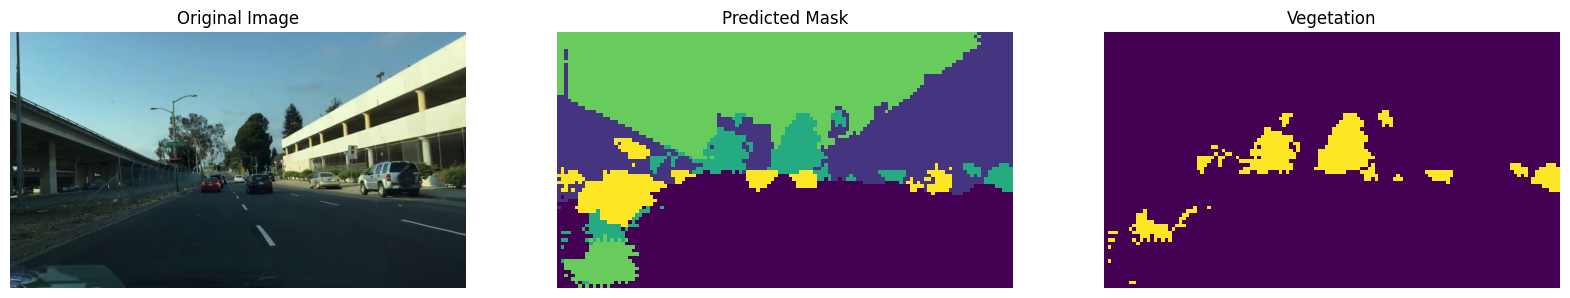

[ 0  2  8 10 13]
['road', 'building', 'vegetation', 'sky', 'car']


In [33]:
# load image from the base image folder

image_path = os.path.join(os.path.join('data', 'bdd100k', 'images', '10k', 'test'), 'aca32929-00000000.jpg')
image = Image.open(image_path)
# turn image to tensor
image_tensor = image_transform(image).unsqueeze(0).to(device)

# predict
model.eval()
with torch.no_grad():
    output = model(image_tensor)

print(output)
output = output.argmax(1).squeeze().cpu().numpy()

# create a mask image
mask_image = Image.fromarray(output.astype(np.uint8))

# plot original image and mask image
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Original Image')
axs[1].imshow(mask_image)
axs[1].axis('off')
axs[1].set_title('Predicted Mask')
axs[2].imshow()

plt.show()

# print unique values from the mask
print(np.unique(output))
# print the class names of the unique values
print([class_dict[class_id] for class_id in np.unique(output)])

### Regularization

[Regularize](https://karpathy.github.io/2019/04/25/recipe/#:~:text=4.-,Regularize,-Ideally%2C%20we%20are)

### Tuning the model

[Tune](https://karpathy.github.io/2019/04/25/recipe/#:~:text=5.-,Tune,-You%20should%20now)

### Ensembles & Leave it training

[Squeeze out the juice](https://karpathy.github.io/2019/04/25/recipe/#:~:text=Squeeze%20out%20the%20juice)